## 작업 중.. 
### (codes에 담긴 종목 중 변동성 돌파 기반으로 매수해야 할 종목이 있는지 추가적으로 데이터 크롤링 후 시각화 예정)

In [1]:
import requests
from bs4 import BeautifulSoup
import re

URL = 'https://finance.naver.com/sise/sise_quant.nhn'
res = requests.get(URL)
# print(res.status_code)

soup = BeautifulSoup(res.text, 'lxml')
stocks = soup.select('.type_2 tr')[2:]

codes = []
keys = ['종목명', '현재가', '전일비', '등락률', '거래량', '시가총액']
result = []
urls = []

for stock in stocks:
    try:
        company = stock.select_one('.tltle').text
        price = stock.select_one('.number').text.replace(',', '')

        if (('인버스' not in company) and ('레버리지' not in company)) and (int(price) <= 26000):
            
            code = stock.select_one('.tltle').attrs['href'][-6:] # 종목코드 가져오기
            codes.append(code)
            
            updown = stock.select('.tah.p11')[0].text # 전일비 가져오기
            percentage = stock.select('.tah.p11')[1].text # 등락률 가져오기
            
            re_updown = re.sub('\t*|\n*|(\<[^\>]*\>)|\n*\t*', '', updown) # 전일비 정규표현식으로 클렌징
            re_percentage = re.sub('\t*|\n*|(\<[^\>]*\>)|\n*\t*', '', percentage) # 등락률 정규표현식으로 클렌징
            
            market = stock.select('td.number')[3].text # 거래량 가져오기
            volumn = stock.select('td.number')[-3].text # 시가총액 가져오기
            
            values = [company, price, re_updown, re_percentage, market, volumn]
            
            info_dict = dict(zip(keys, values))
            result.append(info_dict)
            
            sise_URL = 'https://finance.naver.com/item/sise_day.naver?code=' + code # 각 종목의 시세 탭으로 진입
            urls.append(sise_URL)
#             sise_res = requests.get(sise_URL)
        
        else:
            continue
    except:
        pass
        
    if len(codes) == 5:
        break
        
print(codes) # [type(i) for i in codes]

for r in result:
    print()
    print(r)

print(*urls, sep='\n')

# for url in urls:
#     res = requests.get(url)
#     soup = BeautifulSoup(res.text, 'lxml')

['008420', '026940', '071090', '002140', '008970']

{'종목명': '문배철강', '현재가': '4850', '전일비': '1,095', '등락률': '+29.16%', '거래량': '11,797,688', '시가총액': '994'}

{'종목명': '부국철강', '현재가': '4240', '전일비': '740', '등락률': '+21.14%', '거래량': '5,529,701', '시가총액': '848'}

{'종목명': '하이스틸', '현재가': '5050', '전일비': '640', '등락률': '+14.51%', '거래량': '4,158,978', '시가총액': '1,020'}

{'종목명': '고려산업', '현재가': '6370', '전일비': '190', '등락률': '-2.90%', '거래량': '3,912,787', '시가총액': '1,589'}

{'종목명': '동양철관', '현재가': '1140', '전일비': '65', '등락률': '+6.05%', '거래량': '3,647,904', '시가총액': '1,355'}
https://finance.naver.com/item/sise_day.naver?code=008420
https://finance.naver.com/item/sise_day.naver?code=026940
https://finance.naver.com/item/sise_day.naver?code=071090
https://finance.naver.com/item/sise_day.naver?code=002140
https://finance.naver.com/item/sise_day.naver?code=008970


## 고정 돌파계수 K vs. 시장 상황(전날 추세 - 9/8 목)에 따른 변동 돌파계수 K

#### 날짜, 종가, 전일비, 시가, 고가, 저가, 거래량
 
- 특정 종목의 (전일 고가-전일 저가)가 갑자기 크게 증가한 다음날 (상한가를 치거나 주가가 많이 오른 경우) 
- 전날보다는 못하지만 어느 정도 상승장을 이어가고 있을 때 고정된 돌파계수 0.5 때문에 매수 타이밍을 못 잡는 경우가 생길 수도 있고 
- 반대의 경우, 즉 (전일 고가-전일 저가)가 작았던 다음날 미약한 주가 상승에도 매수를 시도하는 경우가 생기기도 함

In [2]:
import requests
from bs4 import BeautifulSoup

headers = {'user-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:104.0) Gecko/20100101 Firefox/104.0'}
sise_URL = 'https://finance.naver.com/item/sise_day.naver?code=001570'
sise_res = requests.get(sise_URL, headers=headers)
# print(res.status_code)

soup = BeautifulSoup(sise_res.text, 'lxml')
prices = soup.select('.type2 tr')[2]

latest_date = prices.select_one('.tah.p10.gray03').text # 최근 날짜
start_price = int(prices.select('.tah.p11')[2].text.replace(',', '')) # 전날 시가이기 때문에 필요 없음. 당일 시가로 대체해야
end_price = int(prices.select('.tah.p11')[0].text.replace(',', '')) # 종가
highest_price = int(prices.select('.tah.p11')[3].text.replace(',', '')) # 고가
lowest_price = int(prices.select('.tah.p11')[4].text.replace(',', '')) # 저가

# K = 0.5 # 고정 돌파계수 K
K = 1 - (abs(start_price - end_price) / (highest_price - lowest_price)) # 돌파계수 K, 9/8 - 0.85

target_price = start_price + (highest_price - lowest_price) * K # 매수 타켓가

print(prices, f'\n최근 날짜: {latest_date}, \n시가: {start_price}, \n종가: {end_price}, \n고가: {highest_price}, \n저가: {lowest_price}, \n돌파계수 K: {K}, \n매수 타겟가: {target_price}')

fixedK = start_price + (highest_price - lowest_price) * 0.5 # 돌파계수 K가 default 0.5일 때. 매수 타켓가: 19200
flexibleK = start_price + (highest_price - lowest_price) * K # 돌파계수 K가 시장 상황에 따라 0.85일 때. 매수 타켓가: 20950
print(fixedK, flexibleK, f'차이: {flexibleK} - {fixedK} =', abs(flexibleK - fixedK))

<tr onmouseout="mouseOut(this)" onmouseover="mouseOver(this)">
<td align="center"><span class="tah p10 gray03">2022.09.23</span></td>
<td class="num"><span class="tah p11">21,100</span></td>
<td class="num">
<img alt="상승" height="6" src="https://ssl.pstatic.net/imgstock/images/images4/ico_up.gif" style="margin-right:4px;" width="7"/><span class="tah p11 red02">
				1,250
				</span>
</td>
<td class="num"><span class="tah p11">20,050</span></td>
<td class="num"><span class="tah p11">21,150</span></td>
<td class="num"><span class="tah p11">19,600</span></td>
<td class="num"><span class="tah p11">2,699,421</span></td>
</tr> 
최근 날짜: 2022.09.23, 
시가: 20050, 
종가: 21100, 
고가: 21150, 
저가: 19600, 
돌파계수 K: 0.32258064516129037, 
매수 타겟가: 20550.0
20825.0 20550.0 차이: 20550.0 - 20825.0 = 275.0


### 1. 시장 상황(추세)에 따른 돌파계수 K를 구하기 귀해 열흘 치 주가 정보 가져와서 평균을 구하자

### 2. 열흘 치 주가 정보를 고정/변동/평균 K로 운영했을 때 예상 수익을 비교해보자 (백테스트)
- #### 고정 K: -200, 변동 K: -401, 변동 K 평균: -1168

In [23]:
import requests
from bs4 import BeautifulSoup

headers = {'user-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:104.0) Gecko/20100101 Firefox/104.0'}
sise_URL = 'https://finance.naver.com/item/sise_day.naver?code=001570'
sise_res = requests.get(sise_URL, headers=headers)
# print(res.status_code)

soup = BeautifulSoup(sise_res.text, 'lxml')
prices = soup.select('.type2 tr')[2:-1] # 최근 열흘치 주가 정보 가져오기
# print(prices[-1].text)

fixedKprofits = 0
flexibleKprofits = 0
flexibleKs = 0

for price in prices:
#     print(price.text)
    
    try:
        latest_date = price.select_one('.tah.p10.gray03').text # 최근 날짜
        start_price = int(price.select('.tah.p11')[2].text.replace(',', '')) # 전날 시가이기 때문에 필요 없음. 당일 시가로 대체해야
        end_price = int(price.select('.tah.p11')[0].text.replace(',', '')) # 종가
        highest_price = int(price.select('.tah.p11')[3].text.replace(',', '')) # 고가
        lowest_price = int(price.select('.tah.p11')[4].text.replace(',', '')) # 저가
        
        K = 1 - (abs(start_price - end_price) / (highest_price - lowest_price)) # 돌파계수 K, 9/8 - 0.85
        K = round(K, 2)
        flexibleKs += K # 변동 K의 평균 구하기

        fixedKtarget = int(start_price + (highest_price - lowest_price) * 0.5) # 돌파계수 K가 default 0.5일 때 매수 타켓가
        flexibleKtarget = int(start_price + (highest_price - lowest_price) * K) # 돌파계수 K가 시장 상황에 따라 0.85일 때 매수 타켓가

        print(f'날짜: {latest_date}, \n시가: {start_price}, \n종가: {end_price}, \n고가: {highest_price}, \n저가: {lowest_price}, \
              \n변동 돌파계수 K: {K}')
        
        gap = abs(flexibleKtarget - fixedKtarget)
        
        print(f'차이: 변동 K {flexibleKtarget} - 고정 K {fixedKtarget} =', gap)
        
        # 현재가가 매수 타겟가를 넘어서자 마자 매수할 것이고, 종가에 근접한 가격으로 매도할 것이기 때문에 데이 트레이딩 수익 예측이 가능함
        BuyOrDont = highest_price >= flexibleKtarget # 매수 여부 확인
        
        if BuyOrDont == True: # 매수 했을 경우 수익 계산
            fixedKprofit = end_price - fixedKtarget # 고정 K 예상 수익
            flexibleKprofit = end_price - flexibleKtarget # 변동 K 예상 수익

            fixedKprofits += fixedKprofit # 고정 K 예상 누적 수익
            flexibleKprofits += flexibleKprofit # 변동 K 예상 누적 수익
        
            if flexibleKprofit > fixedKprofit:
                versus = '변동 K 승리'

            elif flexibleKprofit < fixedKprofit:
                versus = '고정 K 승리'
                
        else:
            fixedKprofit = 0 # 고정 K 예상 수익
            flexibleKprofit = 0 # 변동 K 예상 수익
            versus = '동점'
        
        print(f'매수 여부(변동 K): {BuyOrDont}')
        print(f'고정 K 예상 수익: {fixedKprofit}, 변동 K 예상 수익: {flexibleKprofit}, 승부: {versus}\n')
        
    except:
        continue
    
print(f'고정 K로 열흘 운용했을 때 예상 수익: {fixedKprofits}, 변동 K로 열흘 운용했을 때 예상 수익: {flexibleKprofits}')
# 고정 K로 열흘 운용했을 때 예상 수익: -200, 변동 K로 열흘 운용했을 때 예상 수익: -401, 변동 K 평균으로 열흘 운용했을 때 예상 수익: -1168

if fixedKprofits < 0 and flexibleKprofits < 0:
    print('경기가 안 좋다.. 하락장!\n')
    
elif fixedKprofits <= 1000 and flexibleKprofits <= 1000:
    print('경기가 그냥 그렇다. 보합권!\n')
    
else:
    print('경기가 좋다! 상승장!\n')
    
print(f'변동 K의 열흘 치 평균: {round(flexibleKs / 10, 2)}')

날짜: 2022.09.23, 
시가: 20050, 
종가: 20000, 
고가: 21350, 
저가: 19600,               
변동 돌파계수 K: 0.97
차이: 변동 K 21747 - 고정 K 20925 = 822
매수 여부(변동 K): False
고정 K 예상 수익: 0, 변동 K 예상 수익: 0, 승부: 동점

날짜: 2022.09.22, 
시가: 16800, 
종가: 19850, 
고가: 20200, 
저가: 16650,               
변동 돌파계수 K: 0.14
차이: 변동 K 17297 - 고정 K 18575 = 1278
매수 여부(변동 K): True
고정 K 예상 수익: 1275, 변동 K 예상 수익: 2553, 승부: 변동 K 승리

날짜: 2022.09.21, 
시가: 16900, 
종가: 17200, 
고가: 17750, 
저가: 16600,               
변동 돌파계수 K: 0.74
차이: 변동 K 17751 - 고정 K 17475 = 276
매수 여부(변동 K): False
고정 K 예상 수익: 0, 변동 K 예상 수익: 0, 승부: 동점

날짜: 2022.09.20, 
시가: 17550, 
종가: 17100, 
고가: 17800, 
저가: 16150,               
변동 돌파계수 K: 0.73
차이: 변동 K 18754 - 고정 K 18375 = 379
매수 여부(변동 K): False
고정 K 예상 수익: 0, 변동 K 예상 수익: 0, 승부: 동점

날짜: 2022.09.19, 
시가: 20750, 
종가: 17300, 
고가: 20850, 
저가: 16100,               
변동 돌파계수 K: 0.27
차이: 변동 K 22032 - 고정 K 23125 = 1093
매수 여부(변동 K): False
고정 K 예상 수익: 0, 변동 K 예상 수익: 0, 승부: 동점

날짜: 2022.09.16, 
시가: 20350, 
종가: 20550, 
고가: 21300, 
저가: 1

In [5]:
import requests
from bs4 import BeautifulSoup

headers = {'user-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:104.0) Gecko/20100101 Firefox/104.0'}
sise_URL = 'https://finance.naver.com/item/sise.naver?code=005930'
sise_res = requests.get(sise_URL, headers=headers)
# print(res.status_code)

soup = BeautifulSoup(sise_res.text, 'lxml')
present_price = int(soup.select('table.type2.type_tax tbody .tah.p11')[0].text.replace(',', ''))
today_opening_price = int(soup.select('table.type2.type_tax tbody .tah.p11')[7].text.replace(',', ''))

print(f'현재가: {present_price}, 오늘 시가: {today_opening_price}')

현재가: 54700, 오늘 시가: 54400


In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import mplfinance as mpf

import html5lib
import warnings

warnings.filterwarnings(action='ignore')

headers = {'user-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:104.0) Gecko/20100101 Firefox/104.0'}
url = 'https://finance.naver.com/item/sise_day.nhn?code=005930&page=1'
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'lxml')

pgrr = soup.find('td', class_='pgRR')
s = str(pgrr.a['href']).split('=')
last_page = s[-1]
last_page

df = pd.DataFrame()
sise_url = 'https://finance.naver.com/item/sise_day.nhn?code=005930'

# for page in range(1, int(last_page)+1): # 전체 기간 주가 가져오기
#     page_url = '{}&page={}'.format(sise_url, page)
#     res = requests.get(page_url, headers=headers)
#     soup = BeautifulSoup(res.text, 'lxml')
#     table = soup.select_one('table', class_='type2') # 현재 페이지에서 클래스가 type2인 table 태그 하나 선택하기
#     table_html = str(table) # 테이블 html 정보를 문자열로 변경하기
#     # 판다스의 read_html 로 테이블 정보 읽기. flavor=None(==lxml), encoding='utf-8' or(<) 'euc-kr' or(<) 'cp949'
#     df = df.append(pd.read_html(table_html, flavor=None, header=0, encoding='cp949')[0])
    
for page in range(1, 4): # 한 달 주가 가져오기
    page_url = '{}&page={}'.format(sise_url, page)
    res = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(res.text, 'lxml')
    table = soup.select_one('table', class_='type2') # 현재 페이지에서 클래스가 type2인 table 태그 하나 선택하기
    table_html = str(table) # 테이블 html 정보를 문자열로 변경하기
    # 판다스의 read_html 로 테이블 정보 읽기. flavor=None(==lxml), encoding='utf-8' or(<) 'euc-kr' or(<) 'cp949'
    df = df.append(pd.read_html(table_html, flavor=None, header=0, encoding='cp949')[0])
    
df = df.dropna()

# df = df.iloc[0:30]
# df = df.iloc[0:]
# df = df.rename(columns={'날짜':'Date', '시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
# df = df.sort_values(by='Date')
# df.index = pd.to_datetime(df.Date)
# df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# mpf.plot(df, title='Celltrion candle chart', type='candle')

# mpf.plot(df, title='Celltrion ohlc chart', type='ohlc')

# kwargs = dict(title='Celltrion customized chart', type='candle',
#     mav=(2, 4, 6), volume=True, ylabel='ohlc candles')
# mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
# s  = mpf.make_mpf_style(marketcolors=mc)
# mpf.plot(df, **kwargs, style=s)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1 to 13
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      30 non-null     object 
 1   종가      30 non-null     float64
 2   전일비     30 non-null     float64
 3   시가      30 non-null     float64
 4   고가      30 non-null     float64
 5   저가      30 non-null     float64
 6   거래량     30 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.9+ KB


In [8]:
df.shape

(30, 7)

In [9]:
df.head()

,날짜,종가,전일비,시가,고가,저가,거래량
1,2022.09.23,54700.0,300.0,54400.0,54900.0,54400.0,2395005.0
2,2022.09.22,54400.0,900.0,54600.0,54700.0,54300.0,12786510.0
3,2022.09.21,55300.0,500.0,55400.0,55500.0,55000.0,11863700.0
4,2022.09.20,55800.0,600.0,56400.0,57000.0,55800.0,14041465.0
5,2022.09.19,56400.0,200.0,56300.0,57000.0,56000.0,12278653.0


### Matplotlib은 한글 지원 안 함. font가 필요함! 아래는 mpl에 font 쓰는 예시

### mplfinance는 한글 지원 안 하나..? 아래 설정 실행해도 한글 깨짐

#### cf. https://github.com/INVESTAR/StockAnalysisInPython/issues/50

In [10]:
import matplotlib as mpl # font 잡는데 필요한 모듈 불러오기
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

font_path = '/mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Font/hana.ttf' # ttf 파일을 jupyter notebook 디렉터리 안에 넣기
font_name = fm.FontProperties(fname=font_path).get_name() # fm으로 font 이름 알아오기
print(font_name) # Malgun Gothic
rc('font', family=font_name) # family는 font를 지칭함

Nanum HaNaSonGeurSsi


In [24]:
# df = df.iloc[0:30]
df = df.iloc[:]
df = df.rename(columns={'날짜':'Date', '시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df = df.sort_values(by='Date')
# df.index = pd.to_datetime(df.Date, format='%y.%m.%d')
# df.index = pd.to_datetime(df['Date'], format='%y.%m.%d')
df.index = pd.to_datetime(df['Date'], infer_datetime_format=True)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

kwargs = dict(title='samsung candle chart', type='candle', 
              mav=(2, 4, 6), volume=True, ylabel='ohlc candles') # mav는 moving average, 이동평균선(복수도 가능)의 기간을 튜플로 전달.
# 일봉 데이터를 기준으로 최근 2/4/6개 종가의 평균값이 라인 차트로 그려지는 것을 확인할 수 있음
mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df, **kwargs, style=s)

KeyError: 'Date'

In [12]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-10,58900.0,59200.0,58600.0,59100.0,18084349.0
2022-08-11,59600.0,60000.0,59300.0,59900.0,15141941.0
2022-08-12,59500.0,60700.0,59400.0,60200.0,10786658.0
2022-08-16,60500.0,61600.0,60300.0,61000.0,15036727.0
2022-08-17,61100.0,61200.0,60300.0,60400.0,9061518.0


In [16]:
kwargs = dict(title='samsung customized candle chart', type='candle', mav=(2, 4, 6), volume=True, ylabel='ohlc candles')
mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df, **kwargs, style=s, savefig=dict(fname='/mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/CandleCharts/samsung_CandleChart.jpg', dpi=100, pad_inches=0.25)) # dpi는 인치당 픽셀 수. 높을 수록 고해상도

ls: 'samsung_CandleChart.jpg.jpg'에 접근할 수 없습니다: 그런 파일이나 디렉터리가 없습니다


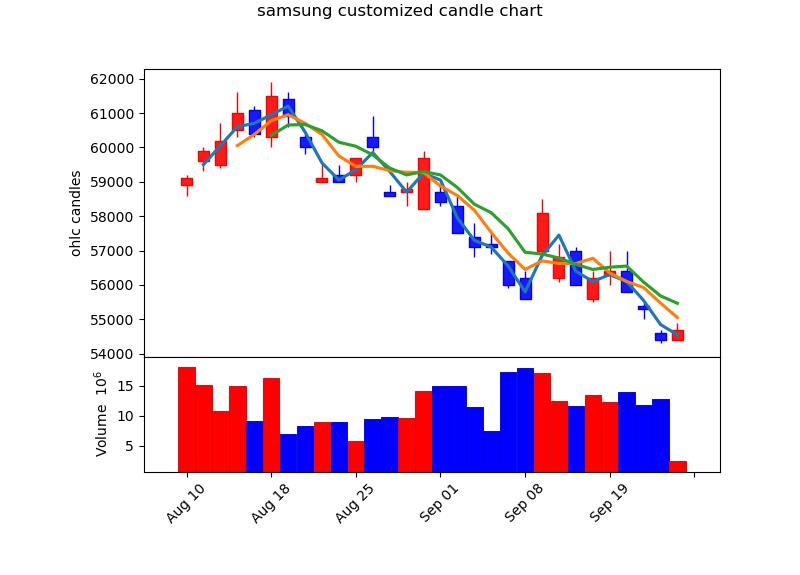

In [19]:
import IPython.display as IPydisplay
# %cd ..
# %cd ~/CandleCharts/
%ls -l samsung_CandleChart.jpg.jpg
IPydisplay.Image(filename='/mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/CandleCharts/samsung_CandleChart.jpg')